# Alpine monatliche Niederschlagsdaten

Alpine monatliche Niederschlagsdaten seit 1871, abgeleitet aus stationären Beobachtungen: Der LAPrec-Datensatz (Long-term Alpine Precipitation Reconstruction) bietet monatliche Niederschlagsdaten für die Alpenregion und basiert auf stationären Beobachtungen. Es gibt zwei Versionen:

* LAPrec1871 (ab 1871, 85 Eingabereihen)
* LAPrec1901 (ab 1901, 165 Eingabereihen)
  
Der Datensatz erfüllt hohe klimatische Standards und ist eine wertvolle Grundlage für historische Klimaanalysen in den Alpen, einer Region, die stark vom Klimawandel betroffen ist. Es kombiniert die Datenquellen HISTALP (homogenisierte stationäre Niederschlagsdaten) und APGD (tägliche Rasterdaten von 1971–2008) und nutzt die Methode der Reduced Space Optimal Interpolation (RSOI). LAPrec wird alle zwei Jahre aktualisiert und wurde im Rahmen des Copernicus Climate Change Service in Zusammenarbeit mit den Wetterdiensten von Schweiz (MeteoSwiss) und Österreich (ZAMG) entwickelt.

**Informationen zum Datensatz:**
* Quelle: [Alpine Monthly Precipitation](https://cds.climate.copernicus.eu/datasets/insitu-gridded-observations-alpine-precipitation?tab=overview)
* Author: T. Tewes (City of Konstanz)
* Notebook-Version: 1.1 (Aktualisiert: Dezember 05, 2024)

## 1. Festlegen der Pfade und Arbeitsverzeichnisse

In [1]:
import os

''' ---- Verzeichnisse hier angeben ---- '''
download_folder = r".\data\alpine-monthly-precipitation\download"
working_folder = r".\data\alpine-monthly-precipitation\working"
geotiff_folder = r".\data\alpine-monthly-precipitation\geotiff"
csv_folder = r".\data\alpine-monthly-precipitation\csv"
output_folder = r".\data\alpine-monthly-precipitation\output"
''' ----- Ende der Angaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Herunterladen und Entpacken des Datensatzes

### 2.1 Authentifizierung

In [2]:
import cdsapi

def main():
    # API-Key für die Authentifizierung
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Erstellung des CDS-API-Clients
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Definieren die „request“ und laden Sie den Datensatz herunter

In [3]:
# Definition des Datensatzes und der Request-Parameter
dataset = "insitu-gridded-observations-alpine-precipitation"
request = {
    "variable": "precipitation",
    "dataset_issue": [
        "laprec1871",
        "laprec1901"
    ],
    "version": ["1_2"],
}

In [4]:
# Führen Sie es aus, um den Datensatz herunterzuladen:
def main_retrieve():
    dataset_filename = f"{dataset}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Den Datensatz nur herunterladen, wenn er noch nicht heruntergeladen wurde
    if not os.path.isfile(dataset_filepath):
        # Rufen Sie den CDS-Client nur auf, wenn der Datensatz noch nicht heruntergeladen wurde.
        client = main()
        # Den Datensatz mit den definierten Anforderungsparametern herunterladen
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Datensatz bereits heruntergeladen.")

if __name__ == "__main__":
    main_retrieve()

Datensatz bereits heruntergeladen.


### 2.3 Extrahieren die ZIP-Datei in Ordner

In [5]:
import zipfile

# Erstellen des Dateinamens und des Dateipfads für die ZIP-Datei des Datensatzes
dataset_filename = f"{dataset}.zip"
dataset_filepath = os.path.join(download_folder, dataset_filename)

# Definieren Sie einen Extraktionsordner für die ZIP-Datei, der dem Arbeitsordner entspricht
extract_folder = working_folder

# Entpacken der ZIP-Datei
try:
    os.makedirs(extract_folder, exist_ok=True)
    
    if not os.listdir(extract_folder):
        # Versuchen Sie, die ZIP-Datei zu öffnen und zu extrahieren
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Dateien erfolgreich extrahiert nach: {extract_folder}")
    else:
        print("Ordner ist nicht leer. Entpacken überspringen.")
except FileNotFoundError:
    print(f"Fehler: Die Datei {dataset_filepath} wurde nicht gefunden.")
except zipfile.BadZipFile:
    print(f"Fehler: Die Datei {dataset_filepath} ist keine gültige ZIP-Datei.")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

Ordner ist nicht leer. Entpacken überspringen.


## 3. Untersuchen der Metadaten der NetCDF4-Datei

In [6]:
# Liste der netCDF4-Dateien im Arbeits-/extrahierten Ordner drucken
filename_list = os.listdir(extract_folder)
print(filename_list)

['LAPrec1871.v1.2.nc', 'LAPrec1901.v1.2.nc']


Der Datensatz <a href="https://cds.climate.copernicus.eu/datasets/insitu-gridded-observations-alpine-precipitation?tab=overview" target="_blank">Monatliche Niederschläge in den Alpen</a> enthält Aufzeichnungen ab 1871 oder 1901. In diesem Notizbuch verwenden wir den Datensatz von 1901 (LAPrec1901).

In [7]:
import netCDF4 as nc

# Definieren Sie den Dateipfad für den ausgewählten NetCDF-Datensatz
nc_filename = "LAPrec1901.v1.2.nc"
nc_filepath = os.path.join(extract_folder, nc_filename)

# Öffnen der NetCDF-Datei im Lesemodus
nc_dataset = nc.Dataset(nc_filepath, mode='r')

# Auflisten aller Variablen im Datensatz
variables_list = list(nc_dataset.variables.keys())
print(f"Verfügbare Variablen: {list(variables_list)}")

Verfügbare Variablen: ['X', 'Y', 'time', 'LAPrec1901', 'lon', 'lat', 'dem', 'lambert_azimuthal_equal_area']


In [8]:
import pandas as pd

# Variablennamen aus vorhandenen Variablen definieren und Variablendaten lesen
variable_name = 'LAPrec1901'
variable_data = nc_dataset[variable_name]

# Erstellen einer Zusammenfassung der Hauptvariablen
summary = {
    "Variablename": variable_name,
    "Datentyp": variable_data.dtype,
    "Form": variable_data.shape,
    "Variableinfo": f"{variable_name}({', '.join(variable_data.dimensions)})",
    "Einheiten": getattr(variable_data, "units", "N/A"),
    "Langer Name": getattr(variable_data, "long_name", "N/A"),
}

# Anzeigen der Zusammenfassung des Datensatzes als DataFrame zur besseren Visualisierung
nc_summary = pd.DataFrame(list(summary.items()), columns=['Beschreibung', 'Bemerkungen'])

# Anzeigen des Zusammenfassungs-DataFrames
nc_summary

,Beschreibung,Bemerkungen
0,Variablename,LAPrec1901
1,Datentyp,int32
2,Form,"(1440, 138, 219)"
3,Variableinfo,"LAPrec1901(time, Y, X)"
4,Einheiten,kg m-2
5,Langer Name,monthly precipitation sum


In [9]:
# Drucken Sie eine Zusammenfassung aller Variablen des Datensatzes
rows = []
for variable in variables_list:
    try:
        var_obj = nc_dataset.variables[variable]
        unit = getattr(var_obj, 'units', 'N/A')
        shape = var_obj.shape
        rows.append({
            "nc_variablen": variable,
            "einheit": unit,
            "form": shape
        })
    except Exception as e:
        print(f"Fehler bei der Verarbeitung der Variable {variable}: {e}")

# Erstelle ein DataFrame
df = pd.DataFrame(rows)
df

,nc_variablen,einheit,form
0,X,m,"(219,)"
1,Y,m,"(138,)"
2,time,days since 1901-01-01 00:00:00,"(1440,)"
3,LAPrec1901,kg m-2,"(1440, 138, 219)"
4,lon,degrees_east,"(138, 219)"
5,lat,degrees_north,"(138, 219)"
6,dem,m,"(138, 219)"
7,lambert_azimuthal_equal_area,N/A,()


## 5. Exportieren der Datensatz im CSV-Format

### 4.1 Begrenzungsrahmen zum Filtern von Daten für Konstanz definieren

In [10]:
# Zusätzliche Anforderungsfelder definieren, um sicherzustellen, dass die Anfrage innerhalb der Dateigrößenbegrenzung bleibt.
# Diese Koordinaten wurden mit dem BBox Extractor Tool erhalten:
# https://str-ucture.github.io/bbox-extractor/

# Begrenzungsbox für die Region Konstanz (WGS84-Projektion):
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]  # Format: [Norden, Westen, Süden, Osten]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # Standardformat: [Westen, Süden, Osten, Norden]

In [11]:
# Alternativ können Sie ein Shapefile für eine präzise geografische Filterung verwenden
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer

# Beispiel: Shapefile von Konstanz laden (WGS84-Projektion)
shapefile = r"./shapefiles/kn_boundary.shp"
gdf = gpd.read_file(shapefile)

# Extrahieren Sie den Begrenzungsrahmen des Shapefiles
shapefile_epsg = gdf.crs.to_epsg()
shapefile_bounds = gdf.total_bounds

# Definieren Sie die Quell- und Zielprojektionen
proj_shapefile = f"epsg:{shapefile_epsg}"  # Quellprojektion (CRS der Shape-Datei)
proj_laea = "epsg:3035"  # Zielprojektion (LAEA für Europa)

# Definieren Sie einen Transformator, um die Koordinaten von der Quell- in die Zielprojektion umzuwandeln
transformer = Transformer.from_crs(proj_shapefile, proj_laea, always_xy=True)

# Transformieren Sie die Koordinaten des Begrenzungsrahmens in die Zielprojektion (LAEA)
x_min, y_min = transformer.transform(shapefile_bounds[0], shapefile_bounds[1])  # Untere linke Ecke
x_max, y_max = transformer.transform(shapefile_bounds[2], shapefile_bounds[3])  # Obere rechte Ecke
shapefile_bounds_laea = [x_min, y_min, x_max, y_max]  # Begrenzungsrahmen in LAEA-Projektion

# Anzeige des transformierten Begrenzungsrahmens
print("Begrenzungsrahmen in LAEA:", shapefile_bounds_laea)

Begrenzungsrahmen in LAEA: [4252254.817823338, 2727132.614227563, 4262344.998739288, 2739095.48723691]


Koordinatensystem: EPSG(4326)
Bounding Box: [ 9.08545411 47.65398657  9.21804389 47.762681  ]


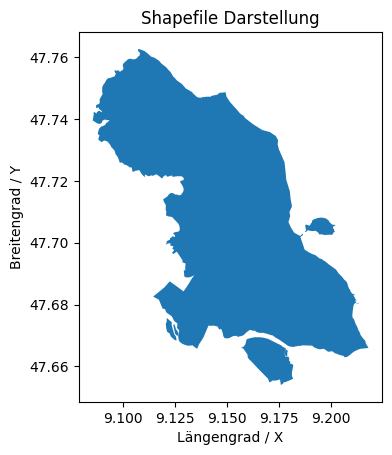

In [12]:
print(f"Koordinatensystem: EPSG({shapefile_epsg})")
print(f"Bounding Box: {shapefile_bounds}")

# Schnelles Plotten Ihres Shapefiles
gdf.plot()
plt.title("Shapefile Darstellung")
plt.xlabel("Längengrad / X")
plt.ylabel("Breitengrad / Y")
plt.show()

> Wichtig: Im Allgemeinen ist **kn_bounds_laea** ausreichend für die Extraktion von CSV- und GeoTIFF-Dateien. Allerdings können Anpassungen erforderlich sein, da:

* **x** und **y** die Mittelpunkte der Rasterzellen darstellen, wodurch die Begrenzungsbox-Kanten möglicherweise nicht genau mit diesen Mittelpunkten übereinstimmen.
* Ohne Anpassung könnten Rasterzellen nahe den Rändern ausgeschlossen werden, wenn die Begrenzungsbox-Kanten zwischen den Zellzentren liegen.
* Eine Anpassung stellt sicher, dass alle relevanten Rasterzellen einbezogen werden.

<div style="display: flex; justify-content: center; gap: 10px;">
  <figure style="margin: 0;">
    <img src="./images/ppt_normal.png" width="400" style="border: 1px solid #aeaeae; display: block;">
    <figcaption style="text-align: center; margin-top: 5px;">Ausdehnung ohne BBox-Anpassung (kn_bounds_laea)</figcaption>
  </figure>
  <figure style="margin: 0;">
    <img src="./images/ppt_adjusted.png" width="400" style="border: 1px solid #aeaeae; display: block;">
    <figcaption style="text-align: center; margin-top: 5px;">Ausdehnung mit BBox-Anpassung (kn_bounds_laea_adjusted)</figcaption>
  </figure>
</div>

Es wird empfohlen, **kn_bounds_laea_adjusted** für die Extraktion von GeoTIFF-Dateien zu verwenden.

In [13]:
# Definiere den Variablennamen aus den verfügbaren Variablen und lese die Variablendaten ein
variable_name = 'LAPrec1901'
variable_data = nc_dataset[variable_name]

x = nc_dataset['X'][:]
y = nc_dataset['Y'][:]

# Validierung der Begrenzungsbox-Dimensionen
dx = x[1] - x[0]  # X-Achsen-Auflösung
dy = y[1] - y[0]  # Y-Achsen-Auflösung

# Anpassung der Begrenzungsbox an die Rasterkanten
x_min_adjusted = max(x_min - dx / 2, x.min())
x_max_adjusted = min(x_max + dx / 2, x.max())
y_min_adjusted = max(y_min - dy / 2, y.min())
y_max_adjusted = min(y_max + dy / 2, y.max())

shp_bounds_laea_adjusted = [x_min_adjusted, y_min_adjusted, x_max_adjusted, y_max_adjusted]
# print(shp_bounds_laea_adjusted)

### 4.2 Daten nach Begrenzungsbox filtern und als CSV exportieren

In [14]:
import xarray as xr

# Funktion zur Konvertierung von NetCDF-Daten in ein Pandas DataFrame
def netcdf_to_dataframe(nc_filepath, bounding_box=None):

    with xr.open_dataset(nc_filepath) as nc_dataset:
        # Zugriff auf die Variablendaten aus dem Dataset
        variable_data = nc_dataset[variable_name]

        # Falls eine Begrenzungsbox angegeben ist, Daten filtern
        if bounding_box:
            filtered_data = variable_data.where(
                (nc_dataset['X'] >= bounding_box[0]) & (nc_dataset['X'] <= bounding_box[2]) &
                (nc_dataset['Y'] >= bounding_box[1]) & (nc_dataset['Y'] <= bounding_box[3]),
                drop=True
            )
        else:
            filtered_data = variable_data

        # Konvertierung des xarray-Datasets in ein Pandas DataFrame
        df = filtered_data.to_dataframe().reset_index().set_index(['time', 'X', 'Y'])

        return df

In [15]:
# Definiere den CSV-Dateinamen und den Dateipfad für die Ausgabe
csv_filename = f"{variable_name}_filtered_data.csv"
csv_filepath = os.path.join(csv_folder, csv_filename)

# Exportiere das DataFrame als CSV, falls es noch nicht existiert
if not os.path.isfile(csv_filepath):
    dataframe = netcdf_to_dataframe(nc_filepath=nc_filepath, bounding_box=shp_bounds_laea_adjusted)
    dataframe.to_csv(csv_filepath, sep=",", encoding='utf8')
else:
    print(f"Datei existiert bereits unter {csv_filepath}.\nExport wird übersprungen.")
    print("Lesen bestehende CSV-Datei ein...")
    dataframe = pd.read_csv(csv_filepath).set_index(['time', 'Y', 'X'])

# Zeige das DataFrame an
dataframe

Datei existiert bereits unter .\data\alpine-monthly-precipitation\csv\LAPrec1901_filtered_data.csv.
Export wird übersprungen.
Lesen bestehende CSV-Datei ein...


LAPrec1901
time       Y         X                    
1901-01-01 2725000.0 4250000.0        37.0
                     4255000.0        36.0
                     4260000.0        36.0
           2730000.0 4250000.0        37.0
                     4255000.0        33.0
...                                    ...
2020-12-01 2735000.0 4255000.0        57.0
                     4260000.0        56.0
           2740000.0 4250000.0        56.0
                     4255000.0        57.0
                     4260000.0        58.0

[17280 rows x 1 columns]

### 4.3 Monatliche Mittelwerte berechnen und als CSV exportieren

In [16]:
# Definiere den CSV-Dateinamen und den Dateipfad für die Ausgabe
csv_filename_monthly_means = f"{variable_name}_monthly_means.csv"
csv_filepath_monthly_means = os.path.join(csv_folder, csv_filename_monthly_means)

# Exportiere die Pivot-Tabelle als CSV, falls sie noch nicht existiert
if not os.path.isfile(csv_filepath_monthly_means):
    # Konvertiere die 'time'-Spalte in das Datetime-Format
    filtered_df_copy = dataframe.copy().reset_index()
    filtered_df_copy['time'] = pd.to_datetime(filtered_df_copy['time'])

    # Extrahiere Jahr und Monat aus der 'time'-Spalte
    filtered_df_copy['Year'] = filtered_df_copy['time'].dt.year
    filtered_df_copy['Month'] = filtered_df_copy['time'].dt.month

    # Gruppiere nach Jahr und Monat, berechne den Mittelwert für die angegebene Variable
    monthly_means = (
        filtered_df_copy.groupby(['Year', 'Month'])[variable_name]
        .mean()
        .reset_index()
        .round({variable_name: 2})
    )

    # Erstelle eine Pivot-Tabelle mit Jahren als Zeilen und Monaten als Spalten
    df_monthly_means = monthly_means.pivot(index='Year', columns='Month', values=variable_name)

    # Stelle sicher, dass alle Monate (1–12) enthalten sind, und füge jährliche Summen hinzu
    df_monthly_means = df_monthly_means.reindex(columns=range(1, 13))
    df_monthly_means[f"Yearly_Sum"] = df_monthly_means.sum(axis=1)
    df_monthly_means.to_csv(csv_filepath_monthly_means, index=True)
    print(f"Monatliche Mittelwerte erfolgreich exportiert nach {csv_filepath}")
else:
    print(f"Datei existiert bereits unter {csv_filepath}. Export wird übersprungen.")
    print("Bestehende CSV-Datei wird eingelesen...")
    df_monthly_means = pd.read_csv(csv_filepath_monthly_means).set_index(['Year'])

# Zeige die Pivot-Tabelle an
df_monthly_means

Datei existiert bereits unter .\data\alpine-monthly-precipitation\csv\LAPrec1901_filtered_data.csv. Export wird übersprungen.
Bestehende CSV-Datei wird eingelesen...


,1,2,3,4,5,6,7,8,9,10,11,12,Yearly_Sum
Year,,,,,,,,,,,,,
1901,31.17,26.00,65.42,124.58,16.50,129.33,84.33,88.00,88.08,36.17,25.33,44.50,759.41
1902,32.00,55.58,53.75,35.92,107.08,72.33,89.25,115.42,78.00,78.92,15.25,79.83,813.33
1903,35.00,27.83,37.00,53.17,39.83,88.50,131.33,100.67,45.00,76.00,81.08,16.58,731.99
1904,29.17,95.75,36.58,60.75,129.83,78.33,22.17,64.00,98.83,34.25,44.92,40.08,734.66
1905,44.08,24.33,84.17,83.67,75.58,64.33,76.42,178.92,117.50,101.50,47.33,37.58,935.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,144.00,90.67,32.08,100.50,154.08,153.42,97.17,62.58,48.75,48.25,70.08,1.42,1003.00
2017,47.58,50.00,49.08,100.50,79.83,82.67,114.75,109.25,75.17,42.17,84.50,89.00,924.50
2018,108.92,41.92,44.33,13.25,84.83,62.08,44.75,69.17,64.75,38.25,13.08,94.92,680.25


### 4.4 Monatliche Durchschnittswerte für einen definierten Zeitraum darstellen

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_monthly_averages(
        start_year=None,
        end_year=None):
    
    """
    Stellt die monatlichen Durchschnittswerte einer Variablen mit
    Fehlerbalken für einen bestimmten Zeitraum dar.

    Parameter:
        start_year (int): Startjahr für den Datensatz (optional).
        end_year (int): Endjahr für den Datensatz (optional).
    """
    # Gefiltertes DataFrame aus der CSV-Datei einlesen
    filtered_df = pd.read_csv(csv_filepath)
    filtered_df['time'] = pd.to_datetime(filtered_df['time'])

    # Bestimmen Sie den Zeitraum
    min_year = min(filtered_df['time'].dt.year)
    max_year = max(filtered_df['time'].dt.year)
    
    # Start- und Endjahr an den verfügbaren Datenbereich anpassen
    if start_year and end_year:
        if start_year < min(filtered_df["time"].dt.year):
            print(f"Das angegebene Startjahr {start_year} liegt vor dem Datenbereich.")
            print(f"Startjahr wird auf {min_year} angepasst.")

        if end_year > max(filtered_df["time"].dt.year):
            print(f"Das angegebene Endjahr {end_year} liegt nach dem Datenbereich.")
            print(f"Endjahr wird auf {max_year} angepasst.")

            start_year = max(start_year, min_year)
            end_year = min(end_year, max_year)
    else:
        start_year = min_year
        end_year = max_year
        
    # Daten für den definierten Zeitraum filtern
    df_period = filtered_df[
        (filtered_df["time"].dt.year >= start_year)
        & (filtered_df["time"].dt.year <= end_year)
    ]

    # Monatliche Statistik berechnen: Mittelwert und Standardabweichung
    monthly_stats = df_period.groupby(df_period['time'].dt.month)[variable_name].agg(['mean', 'std'])

    # Diagramm erstellen
    fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

    # Balkendiagramm mit Fehlerbalken zeichnen
    ax.bar(
        monthly_stats.index,
        monthly_stats['mean'],
        yerr=monthly_stats['std'],
        capsize=5,
        color='skyblue',
        alpha=0.7,
        error_kw=dict(ecolor='black', lw=0.75),
    )

    # Dynamischen Y-Achsenbereich setzen
    y_min = max(0, monthly_stats['mean'].min() - monthly_stats['std'].max() - 0.5)
    y_min = y_min // 20 * 20
    y_max = monthly_stats['mean'].max() + monthly_stats['std'].max() + 0.5
    y_max = (y_max + 20) // 20 * 20
    ax.set_ylim(y_min, y_max)

    # Hilfslinien hinzufügen
    ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # Achsenbeschriftungen und Titel anpassen
    ax.set_xlabel('Monat', fontsize=12)
    ax.set_ylabel('Durchschnittlicher Niederschlag (mm)', fontsize=12)
    ax.set_title(
        f'Durchschnittlicher Niederschlag pro Monat (Zeitraum Jan {start_year} - Dez {end_year})',
        fontsize=14,
        fontweight='bold'
    )

    # X-Achse mit Monatsnamen beschriften
    month_labels = ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_labels, rotation=0)

    # Layout anpassen und Diagramm anzeigen
    plt.tight_layout()
    plt.show()

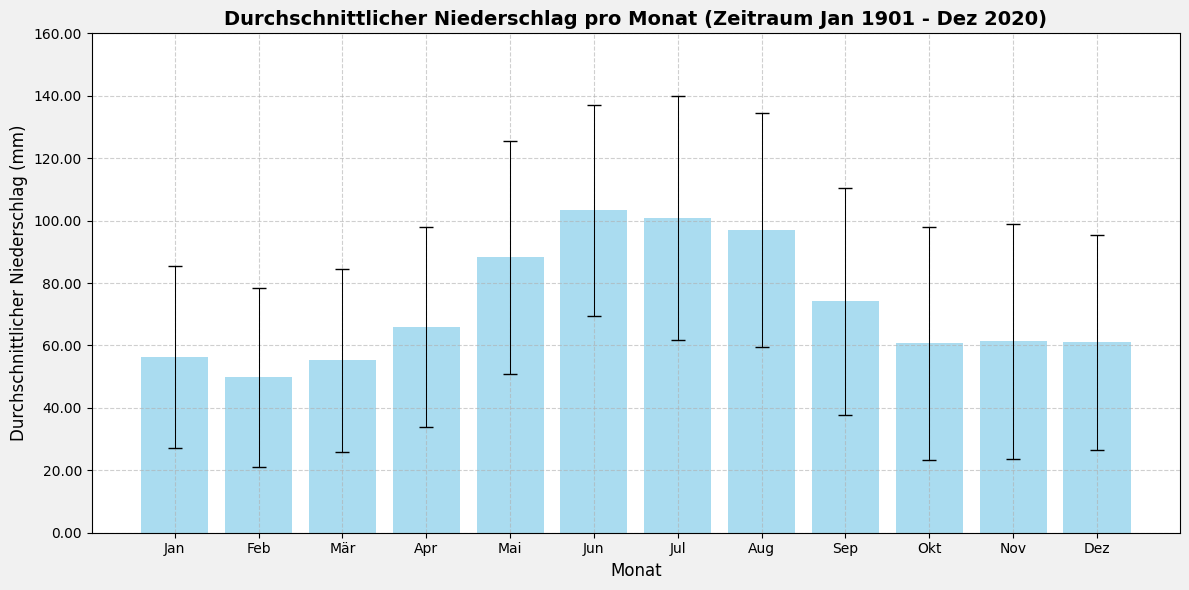

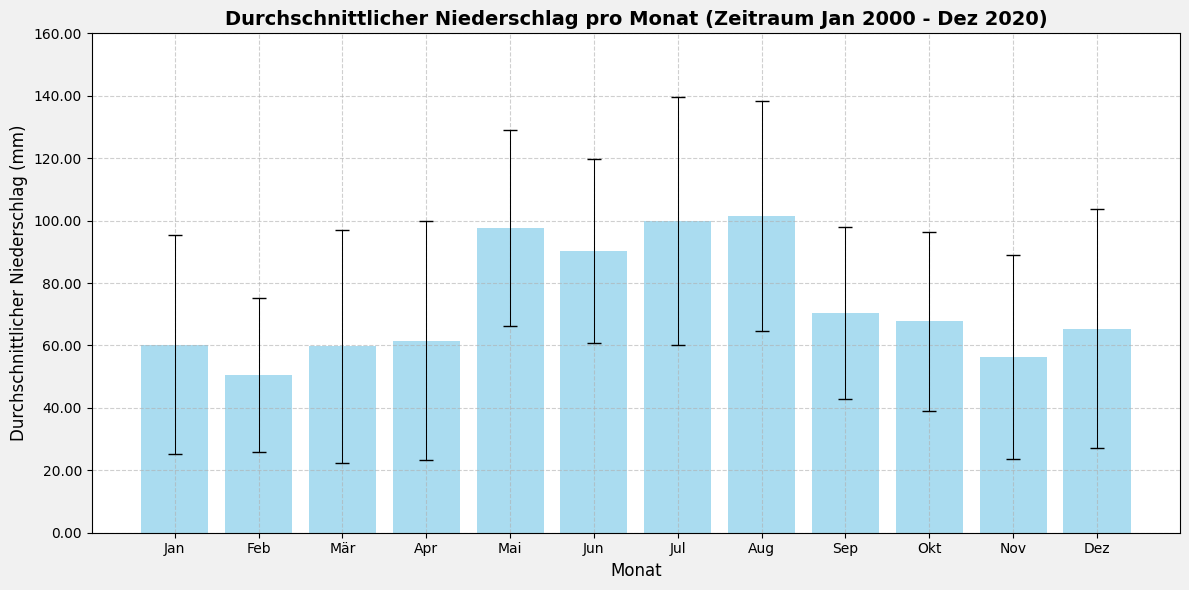

In [18]:
# Geben Sie den Jahresbereich an, um den monatlichen Durchschnitt zu filtern und darzustellen.
# Wenn kein Bereich angegeben wird, wird der komplette Datensatz verwendet.
if __name__ == "__main__":
    plot_monthly_averages()  # Plot mit vollständigem Datensatz
    plot_monthly_averages(2000,2020) # Plot mit angegebenem Jahresbereich

## 5. Exportieren der NetCDF4-Dateien nach GeoTIFF

### 5.1 Definieren eine Funktion zum Exportieren der NetCDF4-Datei als GeoTIFF-Datei(en)

In [19]:
import numpy as np
from rasterio.transform import from_origin
import rasterio

from tqdm.notebook import tqdm

def main_export_geotiff(
    nc_filepath,
    nc_file_variable,
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None):
    """
    Exportieren Sie Niederschlagsdaten als GeoTIFF-Dateien,
    entweder zusammengeführt in einer einzigen Multiband-Datei 
    oder als Einzeldateien für jede Zeitscheibe, mit optionaler räumlicher Filterung.
    
    Parameters:
        nc_filepath (str): Dateipfad der NetCDF4-Datei.
        nc_file_variable (str): Variablenname der NetCDF4-Datei.
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Startjahr für das Dataset (optional).
        end_year (int): Endjahr für das Dataset (optional).
        merged (bool): Gibt an, ob ein zusammengeführtes GeoTIFF oder einzelne GeoTIFFs erstellt werden sollen (optional).
    """

    # Öffnet die NetCDF-Datei
    with nc.Dataset(nc_filepath, mode='r') as nc_dataset:
        x = nc_dataset['X'][:]
        y = nc_dataset['Y'][:]

        # Falls eine Begrenzungsbox angegeben wurde, filtere die Daten entsprechend
        if bounding_box:
            indices_x = np.where((x >= bounding_box[0]) & (x <= bounding_box[2]))[0]
            indices_y = np.where((y >= bounding_box[1]) & (y <= bounding_box[3]))[0]
            start_x, end_x = indices_x[0], indices_x[-1] + 1
            start_y, end_y = indices_y[0], indices_y[-1] + 1
        else:
            start_x, end_x = 0, len(x)
            start_y, end_y = 0, len(y)
        
        x = x[start_x:end_x]
        y = y[start_y:end_y]

        # Extrahiere die Zeitvariable und konvertiere sie in lesbare Datumsangaben
        time_var = nc_dataset.variables['time']
        time_units = nc_dataset.variables['time'].units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        
        # Berechnet die räumliche Auflösung und die Rastertransformation
        dx = abs(x[1] - x[0])
        dy = abs(y[1] - y[0])
        transform = from_origin(x.min() - dx / 2, y.min() - dy / 2, dx, -dy)

        # Bestimmt den verfügbaren Zeitraum
        min_year = cftime[0].year
        max_year = cftime[-1].year

        if start_year and end_year:
            # Passen Sie start_year und end_year basierend auf dem verfügbaren Zeitraum an
            if start_year < min_year:
                print(f"Startjahr {start_year} liegt vor dem Datensatzbereich. Anpassen an {min_year}.")
            if end_year > max_year:
                print(f"Endjahr {end_year} überschreitet den Datensatzbereich. Anpassung an {max_year}.")
            
            start_year = max(start_year, min_year)
            end_year = min(end_year, max_year)
        else:
            # Standardmäßig voller Datensatzbereich
            start_year, end_year = min_year, max_year

        # Findet die Indizes, die dem angegebenen Jahresbereich entsprechen
        start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
        end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 12  # Ganzes Jahr (monatliche Daten)

        # Extrahiert die Niederschlagsdaten für den ausgewählten Bereich.
        precipitation_data = nc_dataset[variable_name]
        precipitation_data_subset = precipitation_data[start_index:end_index,start_y:end_y, start_x:end_x]
        
        if merged:
            # Erstellt ein zusammengeführtes GeoTIFF mit allen Zeitscheiben als separate Bänder
            output_folder = os.path.join(geotiff_folder, "merged_geotiff")
            os.makedirs(output_folder, exist_ok=True)

            output_filename = f"{variable_name}_merged_{start_year}-{end_year}.tif"
            output_filepath = os.path.join(output_folder, output_filename)
            
            # Erstellt eine GeoTIFF-Datei mit mehreren Bändern für jede Zeitscheibe
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(precipitation_data_subset.dtype),
                width = precipitation_data_subset.shape[2],
                height = precipitation_data_subset.shape[1],
                count = precipitation_data_subset.shape[0],
                crs = "EPSG:3035",
                nodata = -9999,
                transform = transform,        
            ) as dst:
                for year_index in tqdm(range(precipitation_data_subset.shape[0]),
                                       desc=f"Exportiere zusammengeführte GeoTIFF-Datei von {start_year} bis {end_year}"):
                    band_data = precipitation_data_subset[year_index, :, :]
                    dt = cftime[start_index + year_index]
                    band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                    
                    # Schreibe jede Jahresscheibe als Band
                    dst.write(band_data, year_index + 1)
                    dst.set_band_description(year_index + 1, band_desc)

        else:
            # Export als einzelne GeoTIFF-Dateien
            output_folder = os.path.join(geotiff_folder, "individual_geotiff")
            os.makedirs(output_folder, exist_ok=True)

            for year_index in tqdm(range(precipitation_data_subset.shape[0]),
                                   desc=f"Exportieren einzelner GeoTIFF-Dateien von {start_year} bis {end_year}"):
                # Bestimmt das Datum für die aktuelle Zeitscheibe
                dt = cftime[start_index + year_index]
                dt_formatted = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

                # Definiert den Speicherort der Ausgabe-GeoTIFF-Datei            
                output_filename = f"{variable_name}_{dt_formatted}.tif"
                output_filepath = os.path.join(output_folder, output_filename)

                # Exportiert die aktuelle Zeitscheibe als GeoTIFF
                with rasterio.open(
                    output_filepath,
                    "w",
                    driver="GTiff",
                    dtype=str(precipitation_data_subset.dtype),
                    width=precipitation_data_subset.shape[2],
                    height=precipitation_data_subset.shape[1],
                    count=1,
                    crs="EPSG:3035",
                    nodata=-9999,
                    transform=transform,
                ) as dst:
                    year_precipitation_data = precipitation_data_subset[year_index, :, :]
                    dst.write(year_precipitation_data, 1)
                    dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")

### 5.2 Export selected NetCDF4 file(s) to GeoTIFF file(s)

In [20]:
# Dateipfade und Variablennamen definieren
nc_filepath = os.path.join(extract_folder, 'LAPrec1901.v1.2.nc')
variable_name = 'LAPrec1901'

if __name__ == "__main__":
    # Exportieren Sie alle NetCDF-Dateien als zusammengeführte GeoTIFF-Dateien.
    main_export_geotiff(
        nc_filepath = nc_filepath,
        nc_file_variable = variable_name,
        bounding_box = None,
        start_year = None,
        end_year = None,
        merged = True
        )
    
    # Alle NetCDF-Dateien als einzelne GeoTIFF-Dateien exportieren
    main_export_geotiff(
        nc_filepath = nc_filepath,
        nc_file_variable = variable_name,
        bounding_box = None,
        start_year = 1995,
        end_year = 2000,
        merged = False,
        )

Exportiere zusammengeführte GeoTIFF-Datei von 1901 bis 2020:   0%|          | 0/1440 [00:00<?, ?it/s]

Exportieren einzelner GeoTIFF-Dateien von 1995 bis 2000:   0%|          | 0/72 [00:00<?, ?it/s]

## 6. Analyse und Visualisierung Optionen

### 6.1 Definieren Sie eine Funktion zur Visualisierung eines NetCDF4-Datensatzes als Heatmap

In [21]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd

def main_plt_plot(selected_year, selected_month, save):
    
    """
    Plottet monatliche Niederschlagsdaten für ein bestimmtes Jahr und Monat.

    Parameter:
        selected_year (str): Das Jahr, das geplottet werden soll (z.B. '2020').
        selected_month (str): Der Monat, der geplottet werden soll (z.B. '08').
        save (bool): Gibt an, ob der Plot als PNG-Datei gespeichert werden soll.
    """
    
    # Dateipfade und Variablennamen definieren
    nc_filepath = os.path.join(extract_folder, 'LAPrec1901.v1.2.nc')
    variable_name = 'LAPrec1901'
    
    # Öffnen des NetCDF-Datensatzes
    nc_dataset = nc.Dataset(nc_filepath, mode='r')
    lon = nc_dataset['lon'][:]
    lat = nc_dataset['lat'][:]

    # Zeitvariable extrahieren und in lesbare Daten umwandeln
    time_var = nc_dataset.variables['time']
    time_units = nc_dataset.variables['time'].units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

    # Daten für das ausgewählte Datum extrahieren
    selected_date = f"{selected_year}-{selected_month}-01"
    target_index = np.where([t.strftime('%Y-%m-%d') == selected_date for t in cftime])[0][0]
    index_data = nc_dataset[variable_name][target_index, :, :]
    
    # Berechnung von vmin, vmax und bins
    vmin = np.floor(np.nanmin(index_data) / 25) * 25
    vmax = np.ceil(np.nanmax(index_data) / 25) * 25
    interval = 25
    bins = int((vmax - vmin) / interval)

    # Erstellen des Plots
    fig, ax = plt.subplots(figsize=(12, 8),
                           facecolor='#f1f1f1',
                           edgecolor='k',
                           subplot_kw={'projection': ccrs.PlateCarree()})

    cmap = plt.get_cmap("rainbow_r", bins)
    pcm = ax.pcolormesh(lon,
                        lat,
                        index_data,
                        cmap=cmap,
                        shading="auto",
                        vmin=vmin,
                        vmax=vmax)

    # Hinzufügen der Shapefile
    konstanz_shp = r".\shapefiles\kn_boundary.shp"
    konstanz_boundary = gpd.read_file(konstanz_shp)
    konstanz_boundary = konstanz_boundary.to_crs(4326)
    konstanz_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=1.2)

    # Hinzufügen einer Farbskala
    ticks = np.linspace(vmin, vmax, num=bins + 1)
    cbar = plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.06, shrink=0.8, ticks=ticks)
    cbar.set_label("Monthly Precipitation [mm]", fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    # Hinzufügen von Kartenmerkmalen
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.75, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.75)
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    # ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')

    # Hinzufügen von Gitterlinien
    gl = ax.gridlines(draw_labels=True,
                      crs=ccrs.PlateCarree(),
                      linewidth=0.5,
                      color='gray',
                      alpha=0.7,
                      linestyle='--')
    gl.top_labels = False 
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    # Hinzufügen von Titel und Achsenbeschriftungen
    fig.text(0.5, 0.175, 'Längengrad', ha='center', fontsize=14)
    fig.text(-0.01, 0.5, 'Breitengrad', va='center', rotation='vertical', fontsize=14)
    ax.set_title(f"Monatlicher Niederschlag, {selected_date}", fontsize=14, fontweight='bold')
    ax.set_aspect("equal")

    # Plot speichern oder anzeigen
    plt.tight_layout()
    if save:
        temp_images_folder = os.path.join(output_folder, "temp_images_folder")
        os.makedirs(temp_images_folder, exist_ok=True)
        image_filepath = os.path.join(temp_images_folder, f"{selected_year}-{selected_month}.png")
        plt.savefig(image_filepath, format='png', bbox_inches='tight')
        print(f"Plot gespeichert unter: {image_filepath}")
    plt.show()

### 6.2 Erstellen einer Heatmap für den Monatsmittelwert

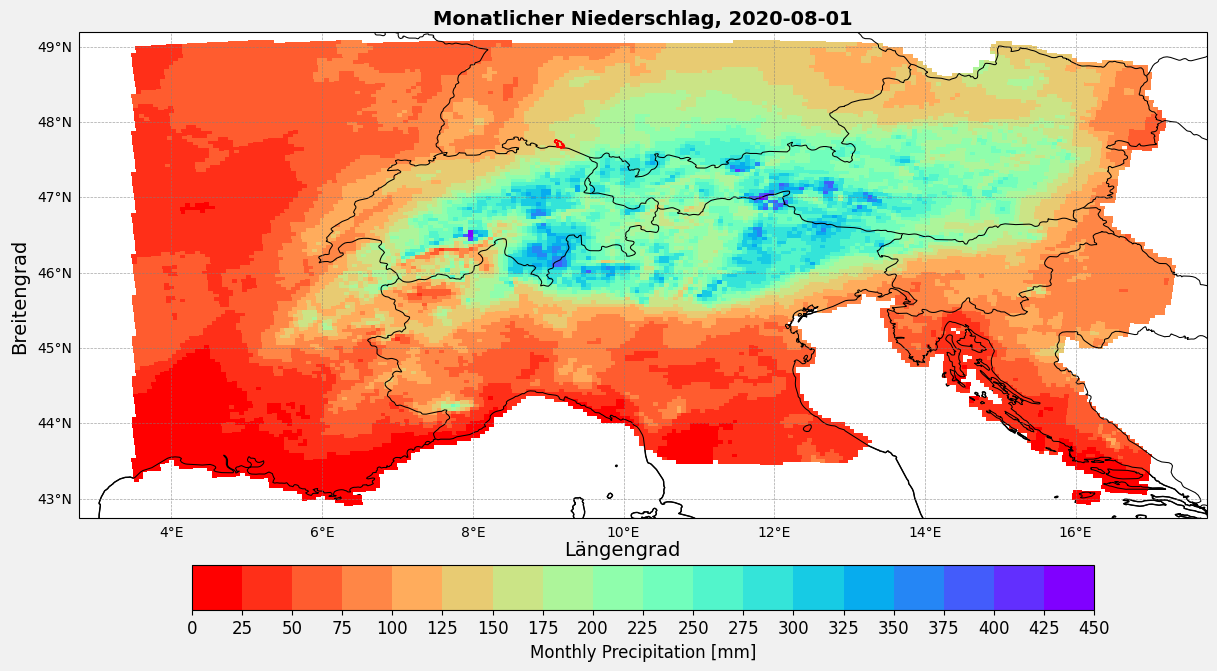

In [22]:
# Beispielhafte Verwendung
if __name__ == "__main__":
    main_plt_plot(
        selected_year='2020',
        selected_month='08',
        save=False,
    )

### 6.3 Definieren Sie eine Funktion zur Visualisierung eines NetCDF4-Datensatzes als monatliche Heatmap

In [23]:
import seaborn as sns

def plot_precipitation_heatmap(start_year=2010,
                               end_year=None):
    """
    Erstellt ein Heatmap der monatlichen durchschnittlichen Niederschläge aus einer CSV-Datei.

    Parameter:
        start_year (int, optional): Das Startjahr zur Filterung der Daten. Standardmäßig 2010.
        end_year (int, optional): Das Endjahr zur Filterung der Daten. Wenn nicht angegeben, wird bis zum maximalen Jahr gefiltert.
    """
    
    # Daten laden und vorverarbeiten
    csv_path = os.path.join(csv_folder, 'LAPrec1901_monthly_means.csv')
    df = pd.read_csv(csv_path)
    df = df.drop(columns=['Yearly_Sum'])  # Jahrensumme entfernen
    df = df.set_index('Year')  # Jahr als Index setzen
    
    # Bestimmen des effektiven Endjahres
    max_year_in_data = df.index.max()
    if end_year is not None:
        end_year = min(max_year_in_data, end_year)
    else:
        end_year = max_year_in_data
    
    # Daten basierend auf dem Start- und Endjahr filtern
    df_filtered = df.loc[start_year:end_year]
    
    # Erstellen des Heatmaps
    fig, ax = plt.subplots(figsize=(12, 8))
    cmap = plt.get_cmap('Blues', 11)
    
    sns.heatmap(
        df_filtered,
        cmap=cmap,
        annot=True,
        annot_kws={"fontsize": 10},
        fmt=".0f",
        cbar_kws={
            "label": f"Niederschlag ({summary.get('Units', 'mm')})",
            "ticks": range(0, 221, 20),
            "pad": 0.015,
        },
        vmin=0,
        vmax=220
    )
    
    # X-Achse mit Monatsnamen anpassen
    month_labels = ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']  
    ticks = range(1, 13)
    shifted_ticks = [tick - 0.5 for tick in ticks]
    # Setzen der Ticks und Labels
    ax.set_xticks(shifted_ticks)
    ax.set_xticklabels(month_labels, rotation=0, fontsize=10)
    
    # Hinzufügen von Beschriftungen und Titel
    ax.set_title("Monatlicher Durchschnittsniederschlag", fontsize=16, fontweight='bold')
    ax.set_xlabel("Monat", fontsize=12)
    ax.set_ylabel("Jahr", fontsize=12)

    # Layout anpassen und Plot anzeigen
    plt.tight_layout()
    plt.show()

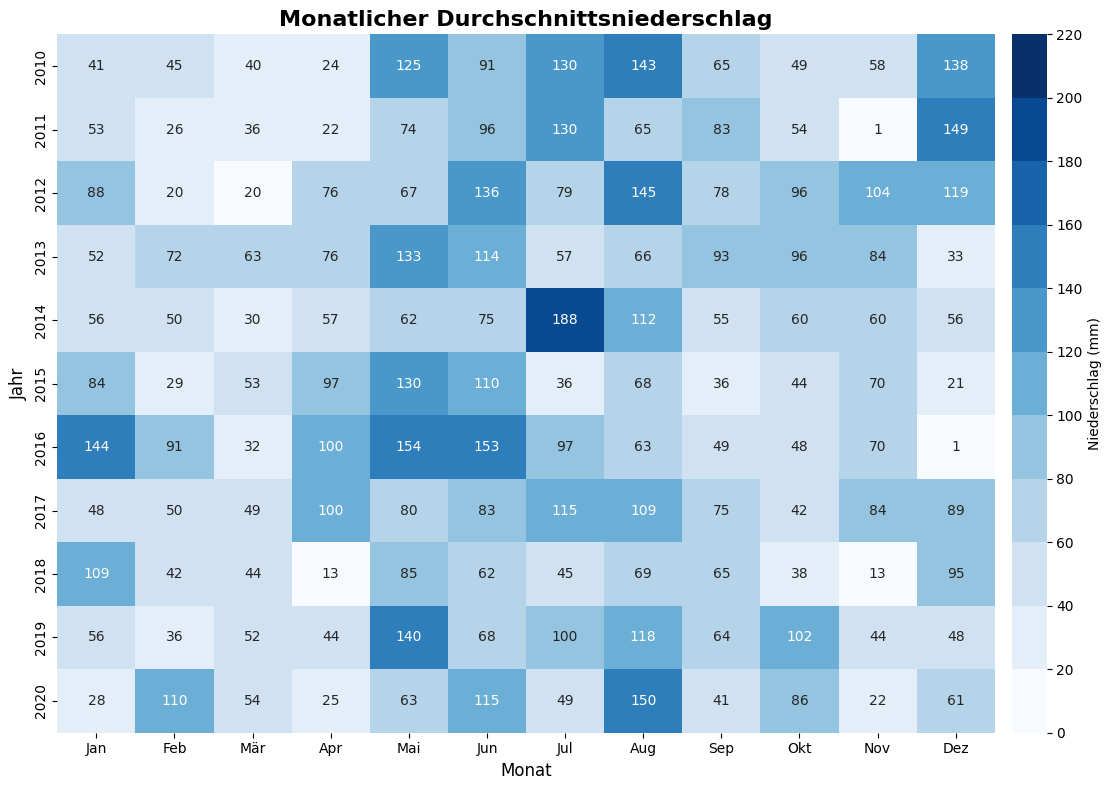

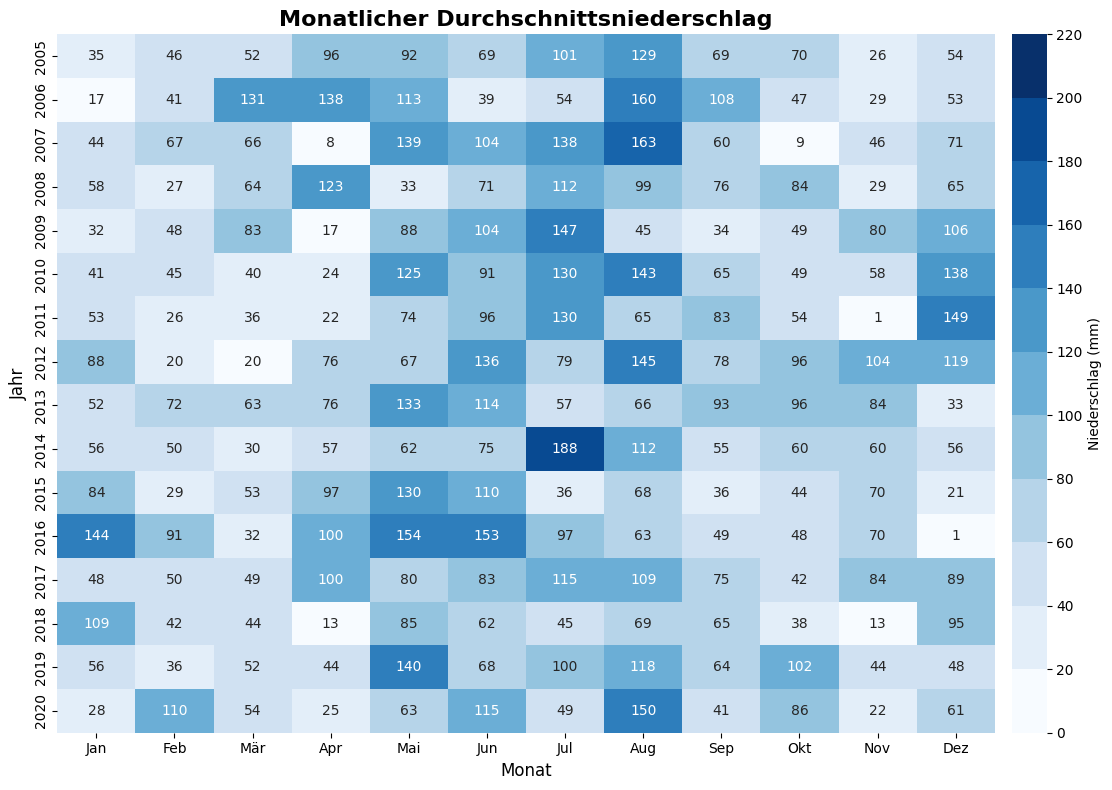

In [24]:
# Beispielhafte Verwendung
if __name__ == "__main__":
    plot_precipitation_heatmap(
        start_year=2010,
        end_year=2020
    )
    
    plot_precipitation_heatmap(
        start_year=2005,
    )